In [20]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofchicago.org,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")



In [44]:
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
rlc_cam = client.get("spqx-js37", #speed cams are at 'hhkd-xvj4' 
                     #where='violation_date > 01-01-2020',
                     where='violation_date BETWEEN \'2015-01-01T00:00:00.000\' AND \'2020-12-20T00:00:00.000\'',
                     limit=1000000,
                    )

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(rlc_cam)

In [47]:
from datetime import datetime
results_df.info()
results_df['violations'] = results_df['violations'].apply(int)
results_df['latitude'] = results_df['latitude'].apply(float)
results_df['longitude'] = results_df['longitude'].apply(float)
results_df['violation_date'] = pd.to_datetime(results_df['violation_date'])
results_df['month'] = results_df['violation_date'].apply(lambda x: x.month)
results_df['weekday'] = results_df['violation_date'].apply(lambda x: datetime.weekday(x))
results_df['year'] = results_df['violation_date'].apply(lambda x: x.year)


results_df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566286 entries, 0 to 566285
Data columns (total 13 columns):
intersection      566286 non-null object
camera_id         566052 non-null object
address           566286 non-null object
violation_date    566286 non-null datetime64[ns]
violations        566286 non-null int64
x_coordinate      536766 non-null object
y_coordinate      536766 non-null object
latitude          536766 non-null float64
longitude         536766 non-null float64
location          536766 non-null object
month             566286 non-null int64
weekday           566286 non-null int64
year              566286 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 56.2+ MB


intersection camera_id                address  \
566281       DAMEN AND DIVERSEY      1462    2800 N DAMEN AVENUE   
566282      CENTRAL AND BELMONT      1604  5600 W BELMONT AVENUE   
566283  CALIFORNIA AND DIVERSEY      1513        2800 W DIVERSEY   
566284       CERMAK AND PULASKI      2332         2200 S PULASKI   
566285      WESTERN AND CHICAGO      1941      800 N WESTERN AVE   

       violation_date  violations       x_coordinate       y_coordinate  \
566281     2015-10-29           5   1162490.04851994  1918611.623717091   
566282     2017-07-27           1  1138453.617438343  1920755.972768412   
566283     2015-05-17           3   1157212.54253358  1918526.674434943   
566284     2018-02-06           3  1150012.876838243   1889071.75851865   
566285     2015-07-01           6  1160220.967978608  1905277.507115921   

         latitude  longitude  \
566281  41.932329 -87.678283   
566282  41.938684 -87.766562   
566283  41.932205 -87.697679   
566284  41.851521 -87.724905   
566285  41.895787 -87.686991   

                                                 location  month  weekday  \
566281  {'latitude': '41.9323294940985', 'longitude': ...     10        3   
566282  {'latitude': '41.93868377475747', 'longitude':...      7        3   
566283  {'latitude': '41.93220539506452', 'longitude':...      5        6   
566284  {'latitude': '41.85152144233116', 'longitude':...      2        1   
566285  {'latitude': '41.89578695485361', 'longitude':...      7        2   

        year  
566281  2015  
566282  2017  
566283  2015  
566284  2018  
566285  2015

In [48]:
import plotly.express as px



df_plot = results_df.groupby(['camera_id', 'intersection', 'latitude', 'longitude', 'address'], as_index=True)['violations'].sum().reset_index()
print(df_plot.head())
df_plot['lat'] = df_plot['latitude'].apply(lambda x: '{:.2f}'.format(x))
df_plot['long'] = df_plot['longitude'].apply(lambda x: '{:.2f}'.format(x))



# fig = px.scatter_geo(results_df.groupby('camera_id').sum(), locations="iso_alpha",
#                      color="violations", # which column to use to set the color of markers
#                      #hover_name="country", # column added to hover information
#                      size="violations", # size of markers
#                      projection="natural earth")

#px.scatter_mapbox?
fig = px.scatter_mapbox(df_plot, 
                        lat="latitude", 
                        lon="longitude", 
                        color="violations",
                        hover_name='intersection',
                        size='violations',
                        #label=['lat','long','violations'],
                        color_continuous_scale='BlueRed', 
                        #range_color=[range_min, range],
                        #center={'lat':41.975605, 'lon': -87.731670},
                        zoom=9.5,
                        opacity=0.6,
                        height=700,
                        hover_data={'camera_id':False, 'lat':False, 'long':':.2f', 'latitude':False} ,
                       )

fig.update_layout(mapbox_style="stamen-toner")  #, hoverlabel={}. MAYBE??
#fig.update_layout (textposition='top left', textfont_size=40)

#fig.update_layout(mapbox_style="open-street-map", height=800)

fig.show()


  camera_id                  intersection   latitude  longitude  \
0      1002            WESTERN AND CERMAK  41.851984 -87.685786   
1      1003            WESTERN AND CERMAK  41.852141 -87.685753   
2      1011          PETERSON AND WESTERN  41.990586 -87.689822   
3      1014          PETERSON AND WESTERN  41.990609 -87.689735   
4      1023  IRVING PARK AND NARRAGANSETT  41.953025 -87.786683   

                 address  violations  
0  2200 S WESTERN AVENUE        9806  
1     2400 W CERMAK ROAD        3396  
2     6000 N WESTERN AVE        7399  
3        2400 W PETERSON       14179  
4       6400 W IRVING PK        4715  


In [49]:
import plotly.express as px



df_plot = results_df.groupby(['weekday', 'latitude', 'longitude', 'month', 'address'])['violations'].sum().reset_index()
#weekday_dfs = []
#for i in range(7):
#    weekday_dfs.append(df_plot = results_df[results_df['weekday']==i])


# fig = px.scatter_geo(results_df.groupby('camera_id').sum(), locations="iso_alpha",
#                      color="violations", # which column to use to set the color of markers
#                      #hover_name="country", # column added to hover information
#                      size="violations", # size of markers
#                      projection="natural earth")

#px.scatter_mapbox?

fig = px.scatter_mapbox(df_plot, 
                        lat="latitude", 
                        lon="longitude", 
                        color="violations",
                        #text='address',
                        animation_frame='weekday',
                        size='violations',
                        hover_name='address',
                        labels=['violations', 'latitude', 'longitude'],
                        color_continuous_scale='Plotly3', 
                        #range_color=[1000, 20000],
                        #center={'lat':41.975605, 'lon': -87.731670},
                        zoom=9.5,
                        opacity=0.6,
                        
                       )
#fig.update_layout(mapbox_style="stamen-toner")
fig.update_layout(mapbox_style="open-street-map", height=800)

fig.show()

   weekday  violations
0        0      424081
1        1      426271
2        2      434378
3        3      455356
4        4      500099
   weekday   latitude  longitude  month          address  violations
0        0  41.677721 -87.642052      1  11900 S HALSTED         168
1        0  41.677721 -87.642052      2  11900 S HALSTED         142
2        0  41.677721 -87.642052      3  11900 S HALSTED         168
3        0  41.677721 -87.642052      4  11900 S HALSTED         148
4        0  41.677721 -87.642052      5  11900 S HALSTED         175
   weekday   latitude  longitude  month          address  violations
0        0  41.677721 -87.642052      1  11900 S HALSTED         168
1        0  41.677721 -87.642052      2  11900 S HALSTED         142
2        0  41.677721 -87.642052      3  11900 S HALSTED         168
3        0  41.677721 -87.642052      4  11900 S HALSTED         148
4        0  41.677721 -87.642052      5  11900 S HALSTED         175
[2015 2019 2017 2016 2018 2020]


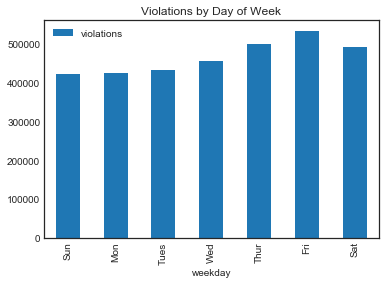

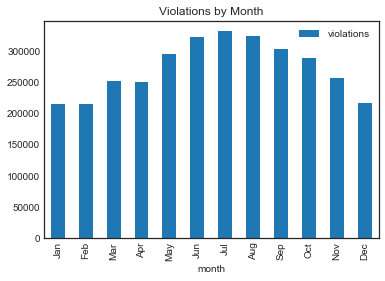

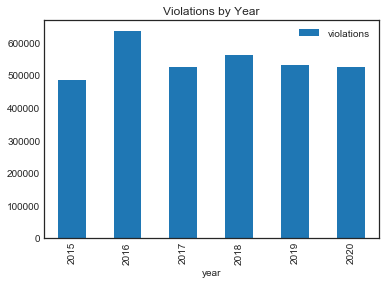

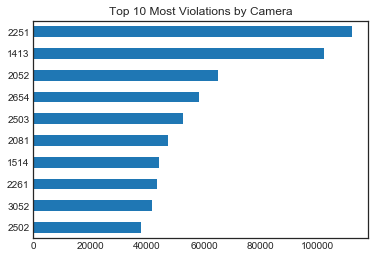

In [51]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-white')


# Weekday plot
df_weekday = results_df.groupby(['weekday'])['violations'].sum().reset_index()
print(df_weekday.head())


ax = df_weekday.plot.bar('weekday', 'violations')
labels = ['Sun', 'Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat']
ax.set_xticklabels(labels)
ax.set_title("Violations by Day of Week")


# Month plot
df_month = results_df.groupby(['month'])['violations'].sum().reset_index()
print(df_plot.head())

ax2 = df_month.plot.bar('month', 'violations')
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax2.set_xticklabels(labels)
ax2.set_title("Violations by Month")


# Year plot
df_year = results_df.groupby(['year'])['violations'].sum().reset_index()
print(df_plot.head())

ax4 = df_year.plot.bar('year', 'violations')
ax4.set_title("Violations by Year")


# top 10 plot
df_top10 = results_df.groupby(['camera_id'])['violations'].sum().reset_index()
df_top10 = df_top10.sort_values(['violations'], ascending=True).tail(10)
ax3 = df_top10.plot.barh(y='violations', x='camera_id')

ax3.set_title("Top 10 Most Violations by Camera")
ax3.set_ylabel('') # post plot, you have to talk to y, even in a barh
ax3.get_legend().remove()



print(results_df['year'].unique())


In [52]:
# basic pd info
print('All Data')
print(results_df['violations'].describe())

print('\n'*2 + 'Weekday Grouped Violations')
print(df_weekday['violations'].describe())

print('\n'*2 + 'Weekday Grouped Violations')
print(df_month['violations'].describe())


All Data
count    566286.000000
mean          5.769166
std           7.473712
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         186.000000
Name: violations, dtype: float64


Weekday Grouped Violations
count         7.000000
mean     466714.000000
std       42740.401028
min      424081.000000
25%      430324.500000
50%      455356.000000
75%      496398.500000
max      534115.000000
Name: violations, dtype: float64


Weekday Grouped Violations
count        12.000000
mean     272249.833333
std       44045.445910
min      214455.000000
25%      241470.500000
50%      271936.500000
75%      307600.750000
max      331496.000000
Name: violations, dtype: float64


In [53]:
results[:1]

NameError: name 'results' is not defined

In [62]:
!pip install plotly==4.1.1
!pip install plotly-express==0.4.0

     |████████████████████████████████| 7.1 MB 3.6 MB/s eta 0:00:01
  Attempting uninstall: plotly
    Found existing installation: plotly 4.9.0
    Uninstalling plotly-4.9.0:
      Successfully uninstalled plotly-4.9.0
You should consider upgrading via the '/Users/aaronlee/opt/anaconda3/envs/learn-env/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/aaronlee/opt/anaconda3/envs/learn-env/bin/python -m pip install --upgrade pip' command.


In [59]:
results_df['year'].unique()

array([2015, 2019, 2017, 2016, 2018, 2020])

In [58]:
# how many rlc do we have by year.  Let's find out when they were OFF


#print(results_df.groupby(['camera_id', 'year']).count().reset_index())
# how many in 2017?
for year in range(2015, 2021):
    print(year, len(results_df[results_df['year']==year].groupby('camera_id').count().reset_index()))

2015 352
2016 305
2017 310
2018 300
2019 300
2020 300


Looks like we had a bunch removed in 2015, and maybe some added at same time.  Thats our experiment.  
Question!!!  What are the start and end dates for each camera??? Probably need to look at each year and catch the start and end date, then label our 50+ cameras for our natural experiment.  We might not have a ton of data to work from.

Proposal:  Crashes were not recorded until 2015.  It wasn't fully mandatroy until Sept 2017 which unfortuantely is where the data is reliable.  However, we can go through every camera from 2015 to 2020 and look at the earliest date and latest date we have in the dataset.  That informs us when the camera went live or when it was shut down.  Reporting was by precinct.  The precinct is in the crash data  

Note:  In EDA, I see a lot of down time on cameras which will mess us up.  It's probably maintenance/road work/malfunction etc.  Probably need to do a check to see when camera is down.  Maybe just look at consecutive days of zero fines (maybe look as SD along with it).  Consecutive zeros can be chopped out of the dataset, or better yet... just fill in the mean for those dates.

In [62]:
# pickle my data to prevent more queries
# import pickle


# with open('all_data.pkl', 'wb') as f:
#     pickle.dump(results_df, f)
    

In [146]:
# let's bring in our data now
import pickle
import pandas as pd


with open('all_data.pkl', 'rb') as f:
    results_df = pickle.load(f)
    
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566286 entries, 0 to 566285
Data columns (total 13 columns):
intersection      566286 non-null object
camera_id         566052 non-null object
address           566286 non-null object
violation_date    566286 non-null datetime64[ns]
violations        566286 non-null int64
x_coordinate      536766 non-null object
y_coordinate      536766 non-null object
latitude          536766 non-null float64
longitude         536766 non-null float64
location          536766 non-null object
month             566286 non-null int64
weekday           566286 non-null int64
year              566286 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 56.2+ MB


In [147]:
cam_list = results_df['camera_id'].unique()


In [148]:
len(cam_list)  # we have 364 total.  That's interesting.  There are some short lived cameras in there.

364

In [170]:
# let's see if we can look at one camera and determine first and last date
# def min_date(my_df, cam_id):
#     start = results_df[results_df['camera_id']==cam_list[i]]['violation_date'].min()
#     #my_df['start'].apply(lambda x: )
#     return start

results_df['start'] = results_df['camera_id'].apply(lambda x: None)
results_df['end'] = results_df['camera_id'].apply(lambda x: None)
#results_df['camera_id'] = results_df['camera_id'].apply(lambda x: int(x))

    
#results_df.head()


In [234]:
#for cam in cam_list:
    #start = results_df[results_df['camera_id']==cam_list[i]]['violation_date'].min()
    #end = results_df[results_df['camera_id']==cam_list[i]]['violation_date'].max()
    #results_df.iloc['camera_id']['start'] = results_df.loc[results_df['camera_id']==cam]['start'] = start
    #results_df.loc[results_df['camera_id']==cam]['end'] = end

#start = results_df[results_df['camera_id']==cam_list[i]]['violation_date'].min()
#results_df = results_df.iloc[:100, :]

print('converting')
results_df['violation_date'] = pd.to_datetime(results_df['violation_date'])

cam_start = results_df.groupby(['camera_id'])['violation_date'].min().reset_index()
cam_end = results_df.groupby(['camera_id'])['violation_date'].max().reset_index()
print("START")
#results_df['start'] = results_df['camera_id'].apply(lambda x: cam_start[cam_start['camera_id']==x])['violation_date']

print('END')
#results_df['end'] = results_df['camera_id'].apply(lambda x: cam_end[cam_end['camera_id']==x][:])

#results_df.head(100)

                                                    


converting
START
END


In [199]:
#import timeit

def get_max(df, cam_id):
    my_max = df[df['camera_id']==cam_id].max()['violation_date']
    return my_max



get_max2(cam_end, '1503')


_results_df = results_df.iloc[:100, :]


# Trying out some possible ways to builde the start end dates into my df
results_df['end'] = results_df['camera_id'].apply(lambda x: get_max2(cam_end, x))

results_df.head()

intersection camera_id                 address  \
0  IRVING PARK AND KILPATRICK      2763  4700 W IRVING PARK ROA   
1       VAN BUREN AND WESTERN      2054  2400 W VAN BUREN STREE   
2           115TH AND HALSTED      2552   11500 S HALSTED STREE   
3  IRVING PARK AND KILPATRICK      2764  4700 W IRVING PARK ROA   
4      ELSTON AND IRVING PARK      1503  3700 W IRVING PARK ROA   

  violation_date  violations x_coordinate y_coordinate  latitude  longitude  \
0     2015-04-09           4          NaN          NaN       NaN        NaN   
1     2015-04-14           5          NaN          NaN       NaN        NaN   
2     2015-04-08           5          NaN          NaN       NaN        NaN   
3     2015-04-19           4          NaN          NaN       NaN        NaN   
4     2015-04-23           3          NaN          NaN       NaN        NaN   

  location  month  weekday  year start        end  
0      NaN      4        3  2015  None 2020-12-06  
1      NaN      4        1  2015  None 2020-12-06  
2      NaN      4        2  2015  None 2017-10-26  
3      NaN      4        6  2015  None 2020-12-06  
4      NaN      4        3  2015  None 2020-12-06

In [204]:

def get_max2(df, cam_id):
    my_minmax = df[df['camera_id']==cam_id]['violation_date'].values[0]
    return my_minmax

get_max2(cam_end, '1503')



numpy.datetime64('2020-12-06T00:00:00.000000000')

In [206]:




# Trying out some possible ways to builde the start end dates into my df
results_df['start'] = results_df['camera_id'].apply(lambda x: get_max2(cam_start, x))

results_df.head()

KeyboardInterrupt: 

In [198]:
results_df.isna().sum()
results_df = results_df[results_df['camera_id'].notna()]
results_df.isna().sum()

intersection           0
camera_id              0
address                0
violation_date         0
violations             0
x_coordinate       29507
y_coordinate       29507
latitude           29507
longitude          29507
location           29507
month                  0
weekday                0
year                   0
start             566052
end               565952
dtype: int64

In [240]:
cam_ends = cam_end.copy()
cam_ends.rename(columns={"violation_date": "end"}, inplace=True)
cam_ends['start'] = cam_ends['camera_id'].apply(lambda x: cam_start[cam_start['camera_id']==x]['violation_date'].values[0])
cam_ends.head()

camera_id        end      start
0      1002 2020-12-06 2015-01-01
1      1003 2020-12-06 2015-01-01
2      1011 2020-12-06 2015-01-02
3      1014 2020-12-06 2015-01-01
4      1023 2020-12-06 2015-01-02

In [231]:
cam_start[cam_start['camera_id']=='2763']['violation_date'].values[0]

numpy.datetime64('2015-01-01T00:00:00.000000000')

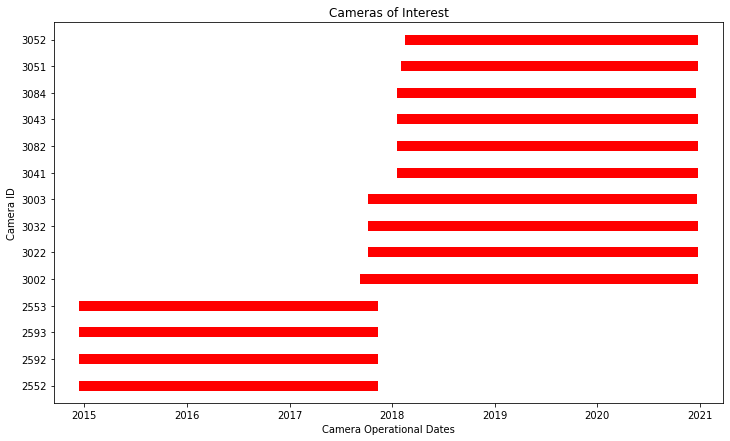

In [329]:
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
#parser.parse("Aug 28 1999 12:00AM")

start = cam_ends['start'].min()
end = cam_ends['end'].max()
x = np.arange(start, end, dtype='datetime64[D]')
cam_ends.sort_values(by=['start', 'end'], ascending=[True, False], inplace=True)


# plot and grab ids for all cams that were installed during timeframe 2017 through current that edned or started
# during the same time
plt.figure(figsize=[12,7])
cams_of_interest = []
for i in range(len(cam_ends)):
    cam = cam_ends.iloc[i]
    if (cam[2] > parser.parse('2017-09-01') or parser.parse('2017-09-01') < cam[1] < parser.parse('2020-10-01')):
        #print(cam[1], "PARSED", parser.parse('2015-04-01'))
        cams_of_interest.append(cam[0])
        plt.plot([cam[1], cam[2]], [cam[0], cam[0]], linewidth=10, linestyle='-', color='red')
    
plt.title('Cameras of Interest')
plt.ylabel('Camera ID')
plt.xlabel('Camera Operational Dates')
plt.show()

In [330]:
len(cams_of_interest)


14

In [331]:
print(cams_of_interest)

['2552', '2592', '2593', '2553', '3002', '3022', '3032', '3003', '3041', '3082', '3043', '3084', '3051', '3052']


10644

In [341]:
# now we need to figure out what those intersections are and the relative time dates for each


interest_df = results_df[results_df['camera_id'].isin(cams_of_interest)]

print(len(interest_df))
# we have 13k accidents with these cams, so maybe enough to do AB test or something

interest_df = interest_df[interest_df['violation_date'] > parser.parse('01-09-17')]

print(len(interest_df))
# after filtering out the ones that were before accurate reporting, we are sadly down to ~10k 

13336
10644


In [342]:
interest_df.columns

Index(['intersection', 'camera_id', 'address', 'violation_date', 'violations',
       'x_coordinate', 'y_coordinate', 'latitude', 'longitude', 'location',
       'month', 'weekday', 'year', 'start', 'end'],
      dtype='object')

In [371]:
# NEED DATA TO SEND FOR NATURAL EXPERIMENT


interest_df.info()
interest_df.longitude.unique()
interest_df.latitude.unique()
interest_df['location'].head()


# clean up my new dataset to be consistendt with locations
cam_address_loc = []

for cam in cams_of_interest:
    address = interest_df[interest_df['camera_id'] == cam]['address'].max()
    intersection = interest_df[interest_df['camera_id'] == cam]['intersection'].max()

    cam_address_loc.append([cam, address, intersection])
    

cam_address_loc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10644 entries, 10 to 566274
Data columns (total 15 columns):
intersection      10644 non-null object
camera_id         10644 non-null object
address           10644 non-null object
violation_date    10644 non-null datetime64[ns]
violations        10644 non-null int64
x_coordinate      8081 non-null object
y_coordinate      8081 non-null object
latitude          8081 non-null float64
longitude         8081 non-null float64
location          8081 non-null object
month             10644 non-null int64
weekday           10644 non-null int64
year              10644 non-null int64
start             0 non-null object
end               10644 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(4), object(7)
memory usage: 1.6+ MB


[['2552', '11500 S HALSTED STREE', '115TH AND HALSTED'],
 ['2592', '10300 S HALSTED STREE', 'HALSTED AND 103RD'],
 ['2593', '800 W 103RD STREET', 'HALSTED AND 103RD'],
 ['2553', '800 W 115TH STREET', '115TH AND HALSTED'],
 ['3002', '5200 N NORTHWEST HWY', 'NORTHWEST HIGHWAY AND FOSTER'],
 ['3022', '5232 N MILWAUKEE AVE', 'MILWAUKEE AND CENTRAL'],
 ['3032', '5232 N CENTRAL AVE', 'CENTRAL AND MILWAUKEE'],
 ['3003', '5616 W FOSTER AVE', 'FOSTER AND NORTHWEST HIGHWAY'],
 ['3041', '300 S MICHIGAN AVE', 'MICHIGAN AND JACKSON'],
 ['3082', '628 N MICHIGAN AVE', 'MICHIGAN AND ONTARIO'],
 ['3043', '100 E JACKSON BLVD', 'MICHIGAN AND JACKSON'],
 ['3084', '100 E ONTARIO ST', 'MICHIGAN AND ONTARIO'],
 ['3051', '200 N UPPER WACKER DR', 'LAKE AND UPPER WACKER'],
 ['3052', '340 W UPPER WACKER DR', 'LAKE AND UPPER WACKER']]

In [414]:
print('Total Cams:', len(results_df.camera_id.unique()))
print()

print('Total Cams of Interest:', len(cams_of_interest))
print('Cams of Interest:', cams_of_interest)
print()

print("Total crashes with na for lat/long:", results_df['location'].isna().sum())
print('Perecentage na for lat/long:', results_df['location'].isna().sum()/len(results_df) * 100)
cams_na = results_df[results_df['location'].isna()]['camera_id'].unique()  # cams that have na values
print('Cams that have na for lat/long:', len(cams_na))
print()
# we are missing the location data for 5% of data


# which cams of interest are also na values?
na_cams_of_interest = []
for cam in cams_na:
    if cam in cams_of_interest:
        if cam not in na_cams_of_interest:
            na_cams_of_interest.append(cam)

print("These {} cams of interest have no location values: {}".format(len(na_cams_of_interest), na_cams_of_interest))

# Since my data 'of interest' is sparse, I will add lat/long and while I'm there, I will just add them for all of the cams


Total Cams: 363

Total Cams of Interest: 14
Cams of Interest: ['2552', '2592', '2593', '2553', '3002', '3022', '3032', '3003', '3041', '3082', '3043', '3084', '3051', '3052']

Total crashes with na for lat/long: 29507
Perecentage na for lat/long: 5.212771971479652
Cams that have na for lat/long: 20

These 4 cams of interest have no location values: ['2552', '3052', '2592', '3051']
